In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

### Load data

In [2]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [3]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [4]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [5]:
def evaluate_models(test_images, sae, dae):
    sae_activations = []
    dae_activations = []
    
    for i in range(len(test_images)):
        test_image = torch.tensor(test_images[i], dtype=torch.float32).reshape(-1)

        with torch.no_grad():
            encoded, _ = sae(test_image)
            sae_encoded = torch.abs(encoded)
            sae_activations.append(sae_encoded)

            encoded, _ = dae(test_image)
            dae_encoded = torch.abs(encoded)
            dae_activations.append(dae_encoded)
        
    return np.mean(np.vstack(sae_activations), axis=0), np.mean(np.vstack(dae_activations), axis=0)

In [6]:
sample_image = torch.tensor(test_images[5], dtype=torch.float32).reshape(-1)
sae = load_model('/home/david/sparsify_models/nl_models/0', 'SAE', 49)
encoded, _ = sae(sample_image)
sae_activation = (encoded)
print(sae_activation)

/tmp/ipykernel_5781/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


tensor([0.0000, 0.0000, 0.0005, 0.1684, 0.0095, 0.0000, 0.0000, 0.0000, 0.2055,
        0.0589, 0.2208, 0.0846, 0.0000, 0.0000, 0.0899, 0.0000, 0.1022, 0.0297,
        0.1357, 0.1978, 0.0760, 0.0000, 0.2389, 0.0000, 0.0000, 0.2424, 0.0000,
        0.0000, 0.2712, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)


In [7]:
def plot_average_activation(results):
    plt.figure(figsize=(12, 8), dpi=300)
    
    sae_data = np.vstack([run[0] for run in results])
    dae_data = np.vstack([run[1] for run in results])

    # Calculate statistics
    sae_mean = np.mean(sae_data, axis=0)
    sae_std = np.std(sae_data, axis=0)
    dae_mean = np.mean(dae_data, axis=0)
    dae_std = np.std(dae_data, axis=0)
    
    # Plot SAE
    plt.plot(sae_mean, color='blue', 
            label=f'SAE', linewidth=2)
    plt.fill_between(range(len(sae_mean)), 
                    sae_mean - sae_std, 
                    sae_mean + sae_std,
                    color='blue', alpha=0.1)
    
    # Plot DAE
    plt.plot(dae_mean, color='red', 
            label=f'DAE', linewidth=2)
    plt.fill_between(range(len(dae_mean)),
                    dae_mean - dae_std,
                    dae_mean + dae_std,
                    color='red', alpha=0.1)
    
    plt.xlabel('Neuron Index', fontsize=16)
    plt.ylabel('Average Activation', fontsize=16)
    # plt.title('Neuron Activation of SAE and DAE Models', fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks([0, 0.1, 0.2], fontsize=16)
    plt.ylim(0, 0.2)
    plt.legend(fontsize=16, loc="upper right", frameon=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("Plots/nl_activation_difference.png", dpi=300, bbox_inches="tight")
    plt.show()

In [8]:
results = []

for iteration in tqdm(range(10), desc=f"Processing models", leave=False):
    modelpath = f'/home/david/sparsify_models/nl_models/{iteration}'
    sae = load_model(modelpath, 'SAE', 49)
    dae = load_model(modelpath, 'DAE', 49)
    
    sae_activations, dae_activations = evaluate_models(test_images, sae, dae)
    results.append((sae_activations, dae_activations))

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5781/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_pa

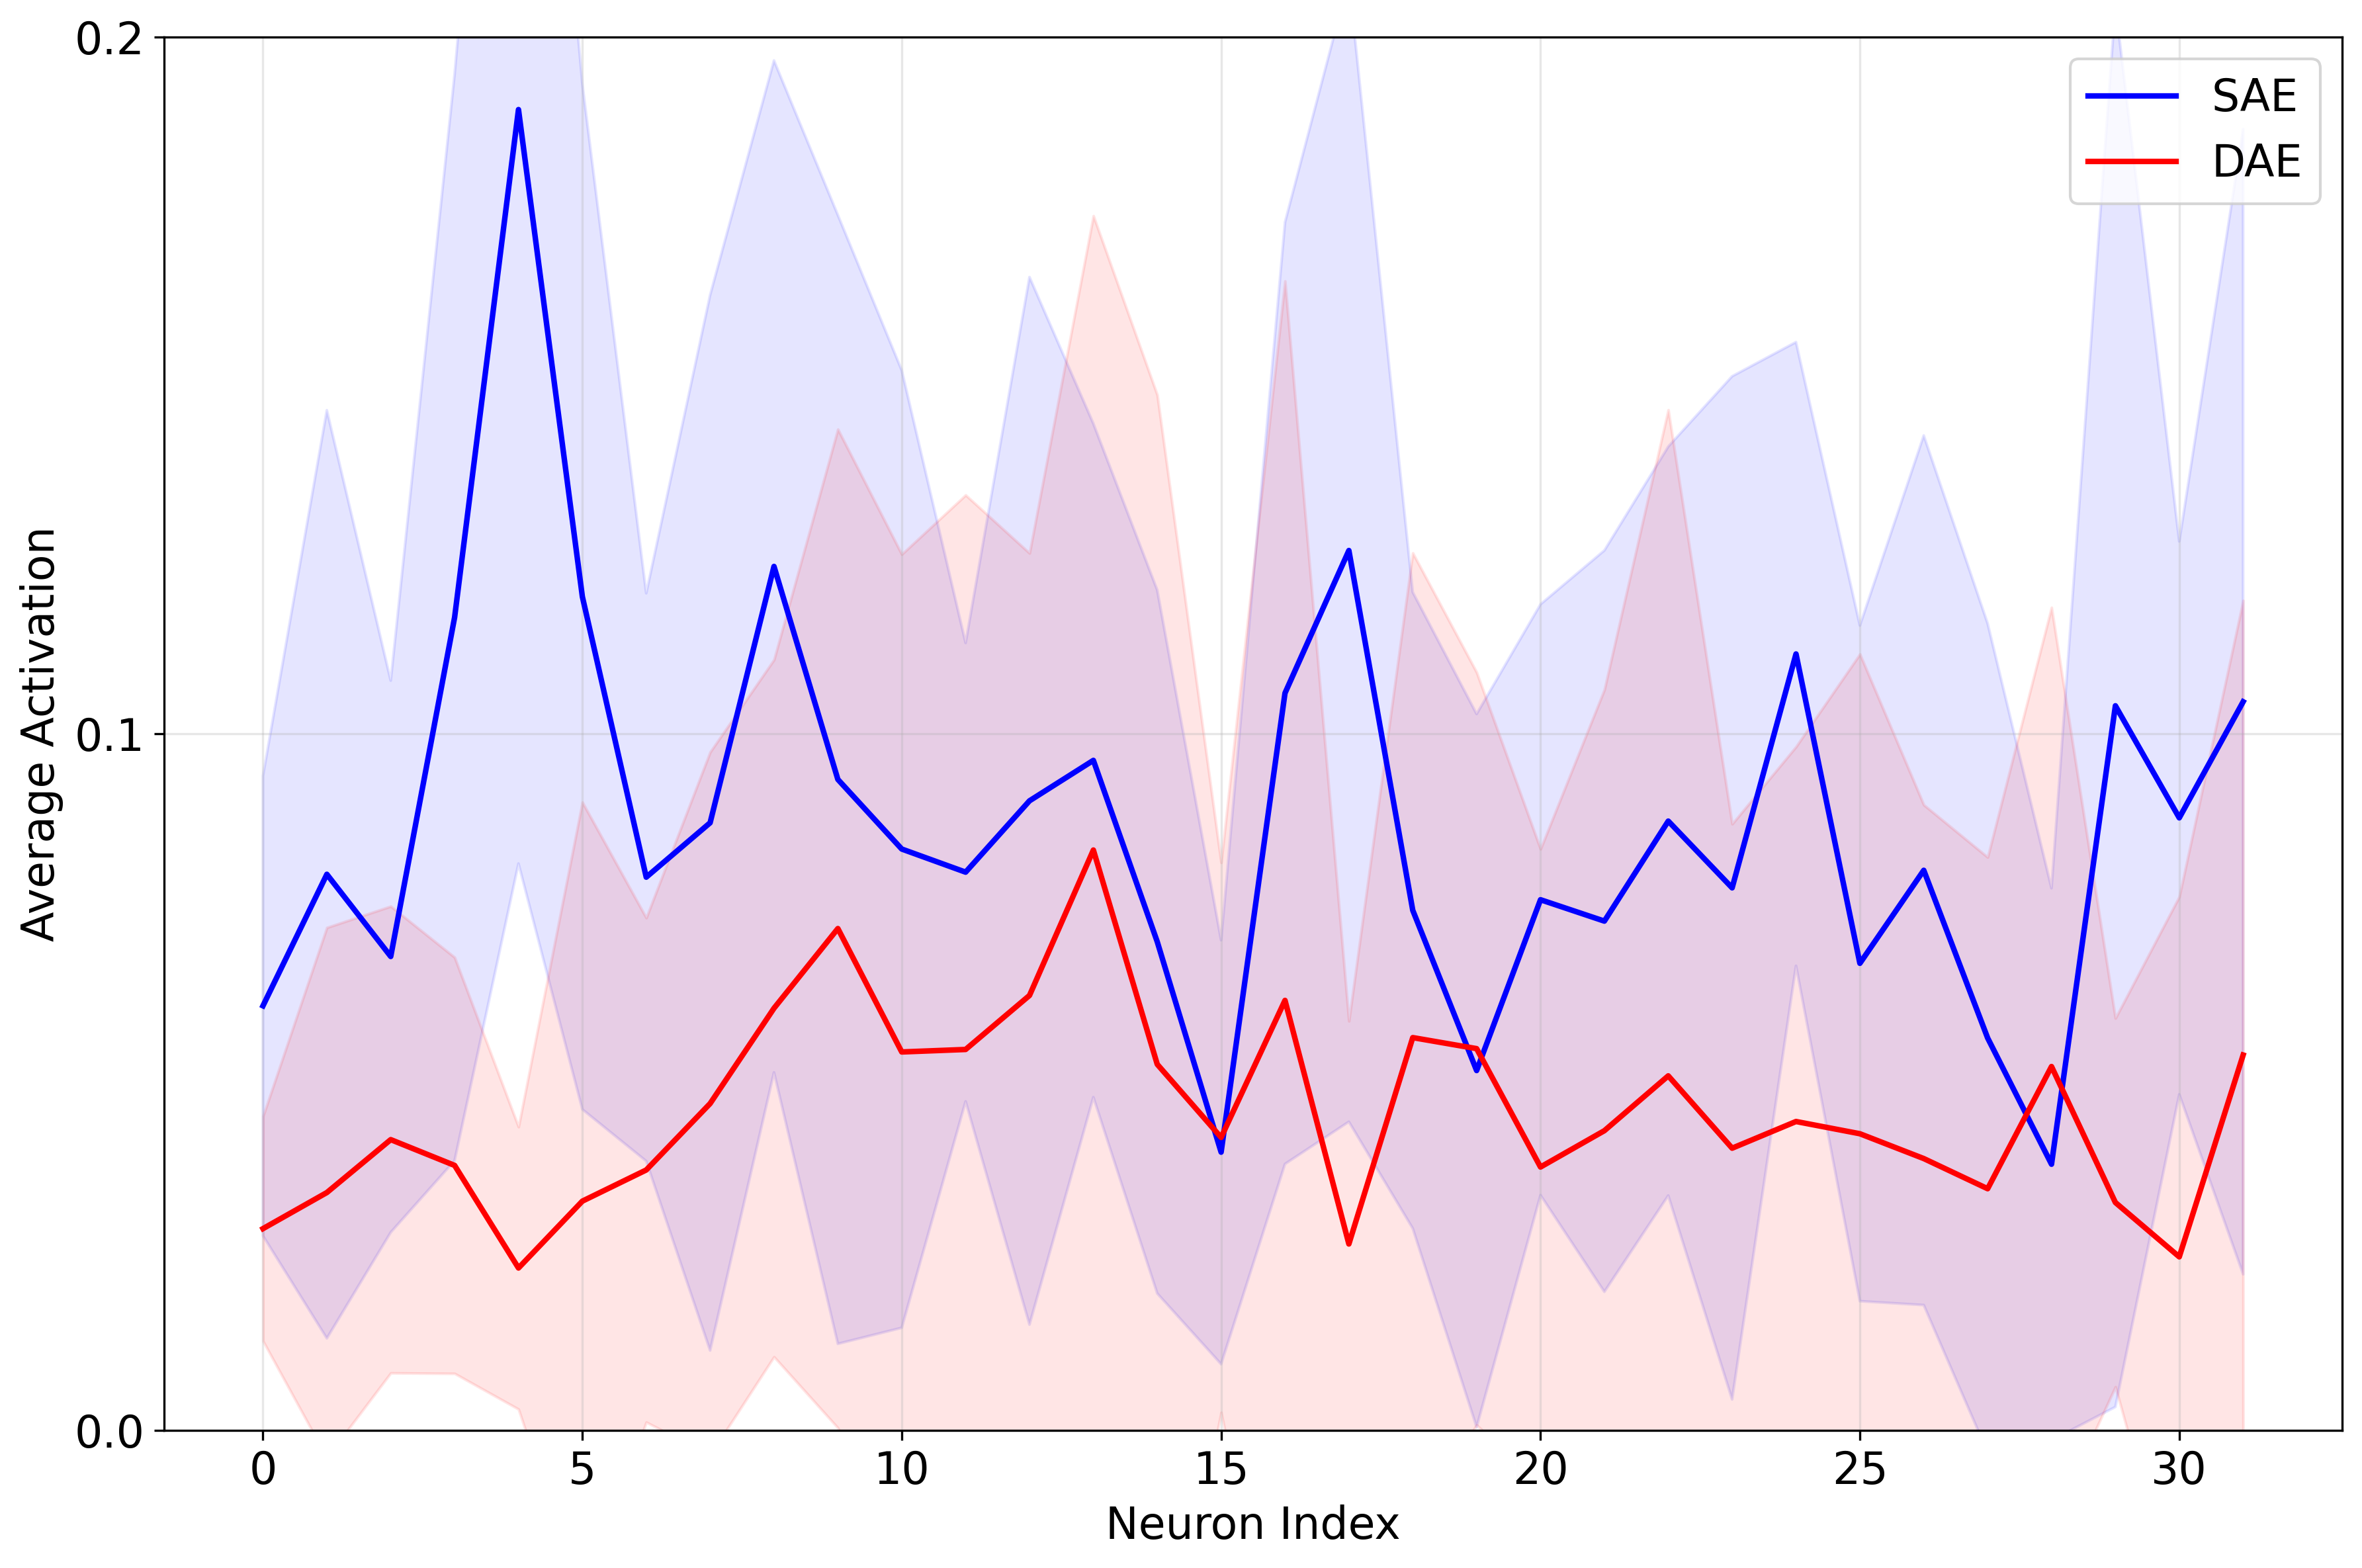

In [10]:
plot_average_activation(results)